<a href="https://colab.research.google.com/github/alvarofpinheiro/pifwia_pso/blob/main/PIFWIA_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PSO - Particle Swarm Optimization ou Otimização por Enxame de Partículas é um método proposto pelos pesquisadores Kennedy e Eberhart em 1995 para resolver problemas de otimização inspirado no comportamento das particulas, buscando melhorar a solução candidata com respeito a uma dada medida de qualidade.

In [ ]:
#instalar biblioteca Orange Canvas
!pip install Orange3

In [ ]:
#bibliotecas
import random
import matplotlib.pyplot as plt
import numpy as np
import Orange

In [ ]:
#hiperparâmetros
DIMENSOES = 6 #determina a quantidade de dimensões do problema
ITERACOES = 200 #quantiddade máxima de ciclos defindo quantas explorações serão feitas (episódios)
POPULACAO = 100 #tamanho da população correspondente ao número de partículas na espaço de busca
E1 = -100 #extremos 1 e 3
E2 = 100 #extremos 2 e 4
LIMITES = [E1,E2] #(bound) determina os valores maximos e minimos do espaço de busca (região de busca)
FCUSTO = 'parábola' #(fitness) função custo que pode ser uma 'esfera' ou 'parábola' ou outra função custo que defina a densidade de partículas na região de busca
CI = 0.8 #(𝑤) coeficiente de inercia que determina o quanto a velocidade anterior influencia na velocidade atual
FI = 2.05 #(𝑐1) fator de individualidade que influencia na atração que a partícula tem em direção à melhor posição já encontrada por ela mesma (𝑃𝑏𝑒𝑠𝑡)
FS = 2.05 #(𝑐2) fator de sociabilidade que influencia na atração que a partícula tem em direção à melhor posição já encontrada por qualquer partícula vizinha a ela (𝐿𝑏𝑒𝑠𝑡)
VM = [-5,5] #velocidade máxima
PARTICULAS = [] #(swarm) array da criação das particulas

In [ ]:
#importação dos dados
from google.colab import files  
files.upload()

In [ ]:
#criação do objeto de dados com base no caminho gerado com a importação do arquivo
dados = Orange.data.Table("/content/dados.csv")

In [ ]:
#exploração dos metadados da base de dados importada
qtde_campos = len(dados.domain.attributes)
qtde_cont = sum(1 for a in dados.domain.attributes if a.is_continuous)
qtde_disc = sum(1 for a in dados.domain.attributes if a.is_discrete)
print("%d metadados: %d continuos, %d discretos" % (qtde_campos, qtde_cont, qtde_disc))
print("Nome dos metadados:", ", ".join(dados.domain.attributes[i].name for i in range(qtde_campos)),)
#exploração dos domínios dos atributos (campos da base de dados)
dados.domain.attributes
#exploração dos dados (quantidade de campos e registros da base de dados)
print("Qtde de Registros:", len(dados))
#exibição dos 5 primeiros registros para análise dos dados importados
i = 0
for d in dados[:5]:
  i += 1
  print(i, d)

7 metadados: 7 continuos, 0 discretos
Nome dos metadados: PROCESSO, ANO, COMPLEXIDADE, PAGINA, PRAZO, REVISOES, ENTREGA
Qtde de Registros: 1013
1 [2022000101, 2019, 3, 12, 10, 4, 36]
2 [2022000102, 2020, 3, 20, 10, 4, 36]
3 [2022000103, 2020, 3, 55, 15, 5, 70]
4 [2022000104, 2018, 4, 43, 10, 4, 36]
5 [2022000105, 2018, 2, 24, 10, 4, 36]


In [ ]:
#criação dos arrays das dimensões do problema
#complexidade
#1 = muito baixa complexidade
#2 = baixa complexidade
#3 = média complexidade
#4 = alta complexidade
#5 = muito alta complexidade
periodo = []
complexidade = []
pagina = []
prazo = []
revisao = []
entrega = []
for d in dados[:POPULACAO]:
  periodo.append(d[1])
  complexidade.append(d[2])
  pagina.append(d[3])
  prazo.append(d[4])
  revisao.append(d[5])
  entrega.append(d[6])
for i in range(POPULACAO):
  print("id:",i+1,"período:",periodo[i],"complexidade:",complexidade[i],"página:",pagina[i],"prazo:",prazo[i],"revisões:",revisao[i],"entrega:",entrega[i])

id: 1 período: 2019 complexidade: 3 página: 12 prazo: 10 revisões: 4 entrega: 36
id: 2 período: 2020 complexidade: 3 página: 20 prazo: 10 revisões: 4 entrega: 36
id: 3 período: 2020 complexidade: 3 página: 55 prazo: 15 revisões: 5 entrega: 70
id: 4 período: 2018 complexidade: 4 página: 43 prazo: 10 revisões: 4 entrega: 36
id: 5 período: 2018 complexidade: 2 página: 24 prazo: 10 revisões: 4 entrega: 36
id: 6 período: 2019 complexidade: 1 página: 93 prazo: 15 revisões: 3 entrega: 42
id: 7 período: 2018 complexidade: 3 página: 44 prazo: 10 revisões: 5 entrega: 45
id: 8 período: 2020 complexidade: 2 página: 37 prazo: 10 revisões: 5 entrega: 45
id: 9 período: 2020 complexidade: 1 página: 11 prazo: 10 revisões: 2 entrega: 18
id: 10 período: 2019 complexidade: 1 página: 10 prazo: 5 revisões: 2 entrega: 8
id: 11 período: 2020 complexidade: 2 página: 32 prazo: 10 revisões: 5 entrega: 45
id: 12 período: 2019 complexidade: 2 página: 13 prazo: 10 revisões: 3 entrega: 27
id: 13 período: 2020 comple

In [ ]:
#particula - unidade base da otimização, posicionada numa determinada posição no espaço de busca do problema, representando uma solução em potencial para o problema
class Particula:
  def __init__(self):
    self.lista_posicao = []
    self.lista_velocidade = []
    self.fitness = np.inf
    self.fitness_pbest = np.inf
    self.lista_posicao_pbest = []

In [ ]:
#função fitness ou objetivo ou otimização - usada para verificação se o mínimo global está dentro de uma função custo determinada pelo argumento
def custo(posicao): 
  return sum([coord ** 2 for coord in posicao])
def fitness(problema, posicoes):
  total = 0
  if problema == 'esfera':
    for i in range(DIMENSOES):
      total += posicoes[i]**2  
  elif problema == 'parábola':
    for i in range(DIMENSOES-1):
      total += 100*(posicoes[i+1] - posicoes[i]**2)**2 + (1-posicoes[i])**2 #rosenbrock
  elif problema == 'custo':
    for i in range(DIMENSOES-1):
      total += 1 / abs(custo(posicoes))
  else:
    print('Problema não encontrado!')
  return total

In [ ]:
#inicialização da população (particulas)
for i in range(POPULACAO):
  p = Particula()
  for j in range(DIMENSOES):
    cpx = complexidade[i] + j
    pag = pagina[i] + j
    posicao = random.uniform(LIMITES[0], LIMITES[1])
    p.lista_posicao.append(posicao)
    p.lista_velocidade.append(random.uniform(VM[0], VM[1]))
  PARTICULAS.append(p)

Plano Cartesiano


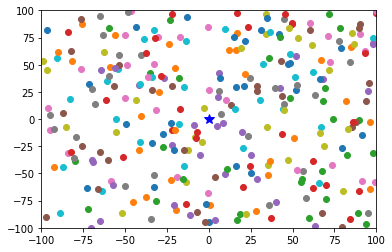

In [ ]:
#posições iniciais das particulas
print("Plano Cartesiano")
plt.axis([E1, E2, E1, E2])
plt.plot(0,0, marker='*', markersize=10, color='b')
for i in range (POPULACAO):
  p = PARTICULAS[i]
  #variáveis das DIMENSÕES do problema
  d1,d2,d3,d4,d5,d6 = zip(p.lista_posicao)
  plt.plot(d1,d2,d3,d4,d5,d6, marker='o')
plt.show()

In [ ]:
#cálculo do fitness
def calculo_fitness(particula):
  particula.fitness = fitness(FCUSTO, particula.lista_posicao)
  if (particula.fitness < particula.fitness_pbest):
    particula.fitness_pbest = particula.fitness
    particula.lista_posicao_pbest = list(particula.lista_posicao)

In [ ]:
#cálculo da velocidade
def atualizacao_velocidade_global(particula, lista_gbest):
  for i in range(DIMENSOES):
    e1 = random.random()
    e2 = random.random()
    velocidade_cognitiva = FI*e1* (particula.lista_posicao_pbest[i] - particula.lista_posicao[i])
    velocidade_social = FS*e2* (lista_gbest[i] - particula.lista_posicao[i])
    v = CI * particula.lista_velocidade[i] + velocidade_cognitiva + velocidade_social
    if v > LIMITES[1]:
      v = LIMITES[1]
    elif v < LIMITES[0]:
      v = LIMITES[0]
    particula.lista_velocidade[i] = v

In [ ]:
#atualização da posição da partícula
def atualiza_posicao(particula, bound):
  for i in range(DIMENSOES):
    novo_valor = particula.lista_posicao[i] + particula.lista_velocidade[i]
    if novo_valor > bound[1]:
      novo_valor =  bound[1]
    if novo_valor < bound[0]:
      novo_valor = bound[0]
    particula.lista_posicao[i] = novo_valor

Iteração: 1


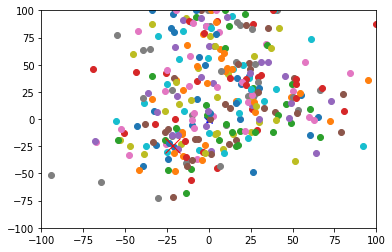

Melhor Ponto: 166912571.20186946

Iteração: 2


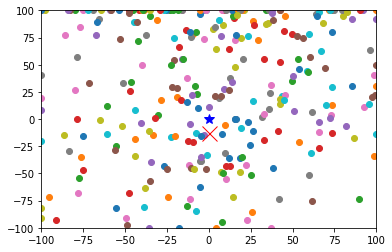

Melhor Ponto: 13638734.50762725

Iteração: 3


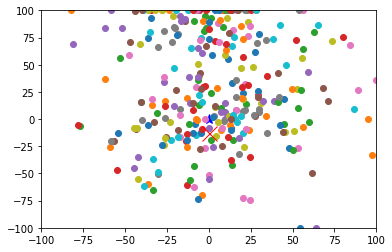

Melhor Ponto: 13638734.50762725

Iteração: 4


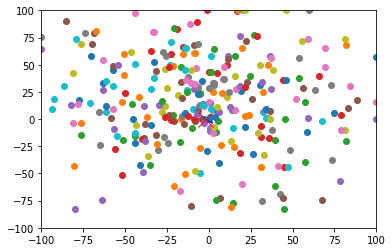

Melhor Ponto: 40799.71532986767

Iteração: 5


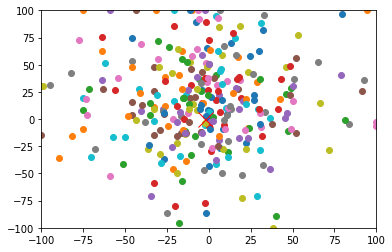

Melhor Ponto: 40799.71532986767

Iteração: 6


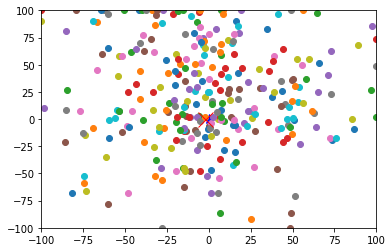

Melhor Ponto: 40799.71532986767

Iteração: 7


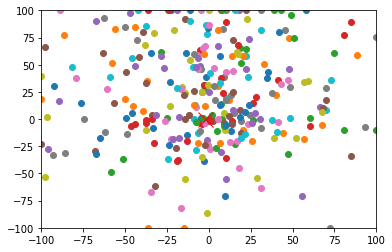

Melhor Ponto: 40799.71532986767

Iteração: 8


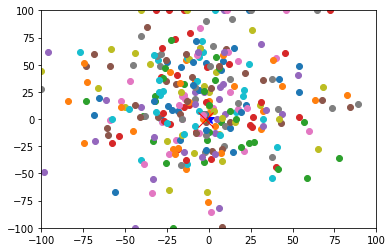

Melhor Ponto: 40799.71532986767

Iteração: 9


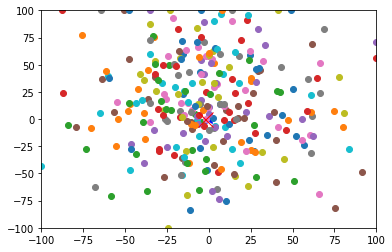

Melhor Ponto: 40799.71532986767

Iteração: 10


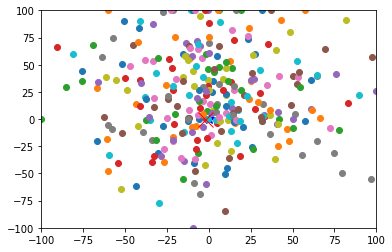

Melhor Ponto: 40799.71532986767

Iteração: 11


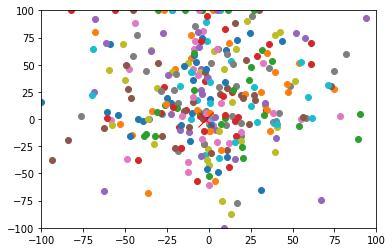

Melhor Ponto: 40799.71532986767

Iteração: 12


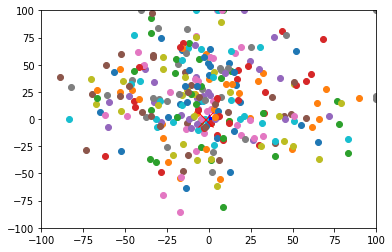

Melhor Ponto: 40799.71532986767

Iteração: 13


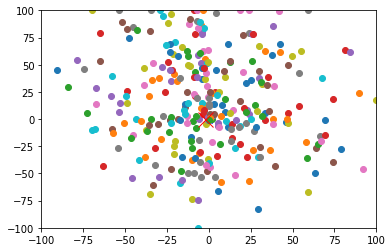

Melhor Ponto: 40799.71532986767

Iteração: 14


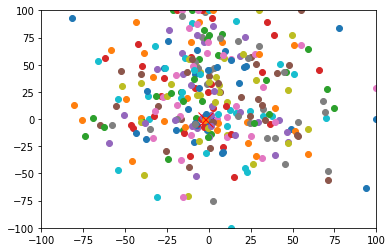

Melhor Ponto: 40799.71532986767

Iteração: 15


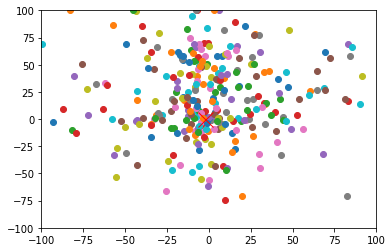

Melhor Ponto: 40799.71532986767

Iteração: 16


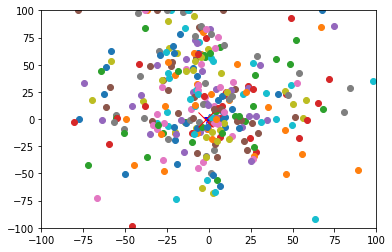

Melhor Ponto: 40799.71532986767

Iteração: 17


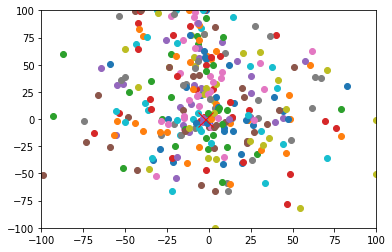

Melhor Ponto: 40799.71532986767

Iteração: 18


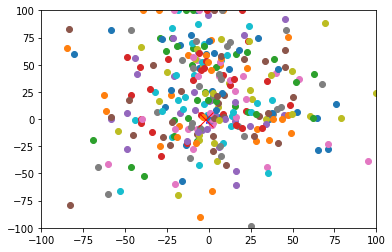

Melhor Ponto: 40799.71532986767

Iteração: 19


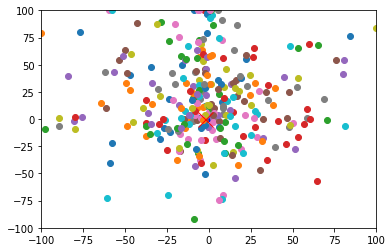

Melhor Ponto: 40799.71532986767

Iteração: 20


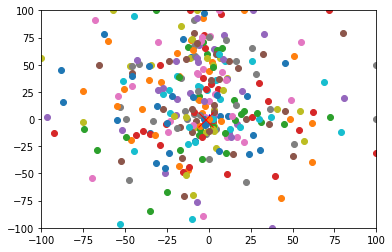

Melhor Ponto: 40799.71532986767

Iteração: 21


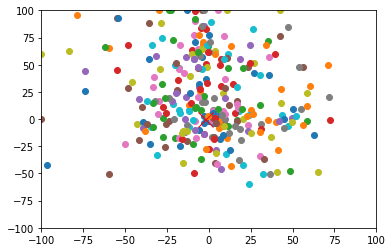

Melhor Ponto: 40799.71532986767

Iteração: 22


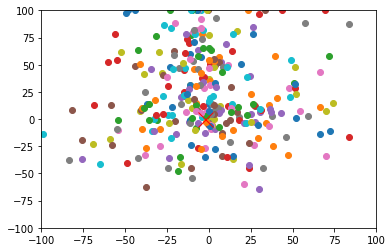

Melhor Ponto: 40799.71532986767

Iteração: 23


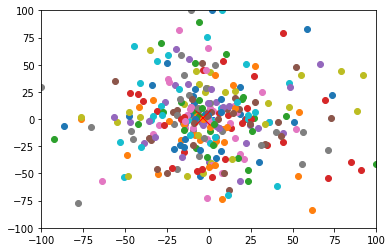

Melhor Ponto: 30094.945111524303

Iteração: 24


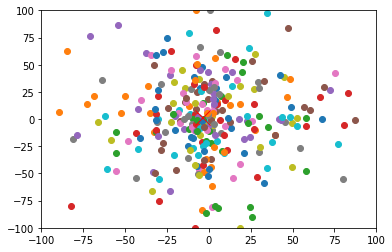

Melhor Ponto: 30094.945111524303

Iteração: 25


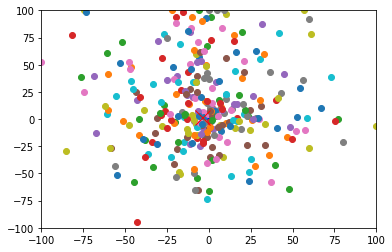

Melhor Ponto: 30094.945111524303

Iteração: 26


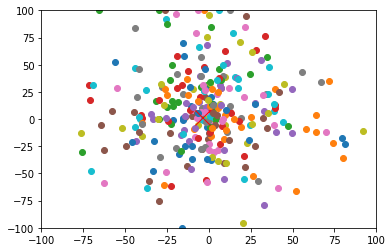

Melhor Ponto: 30094.945111524303

Iteração: 27


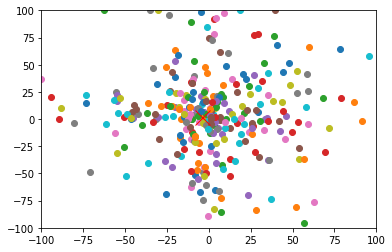

Melhor Ponto: 30094.945111524303

Iteração: 28


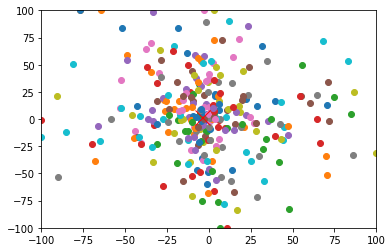

Melhor Ponto: 30094.945111524303

Iteração: 29


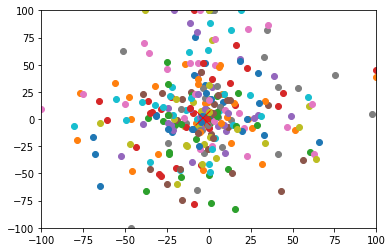

Melhor Ponto: 30094.945111524303

Iteração: 30


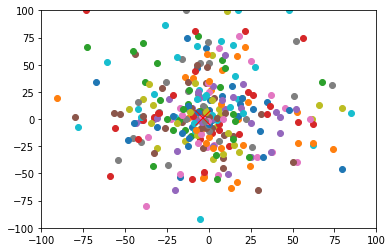

Melhor Ponto: 30094.945111524303

Iteração: 31


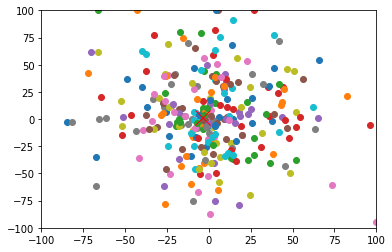

Melhor Ponto: 30094.945111524303

Iteração: 32


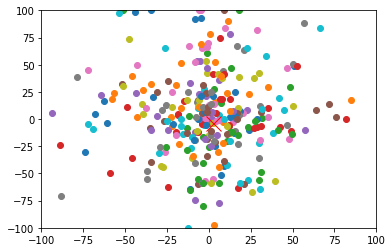

Melhor Ponto: 27079.114717299934

Iteração: 33


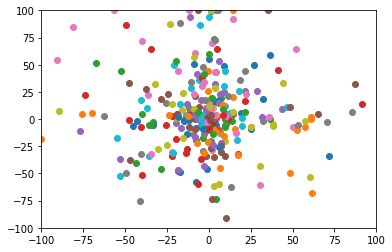

Melhor Ponto: 27079.114717299934

Iteração: 34


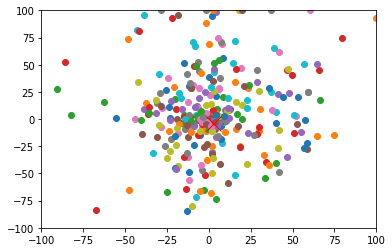

Melhor Ponto: 27079.114717299934

Iteração: 35


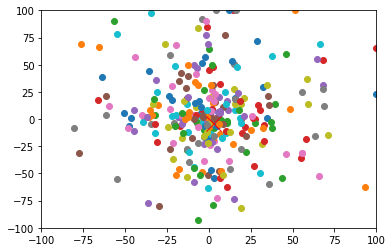

Melhor Ponto: 27079.114717299934

Iteração: 36


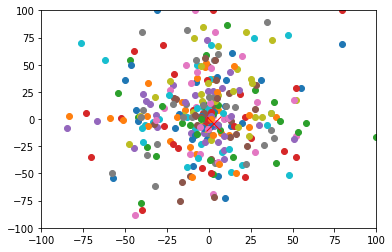

Melhor Ponto: 27079.114717299934

Iteração: 37


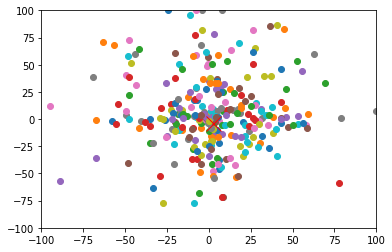

Melhor Ponto: 27079.114717299934

Iteração: 38


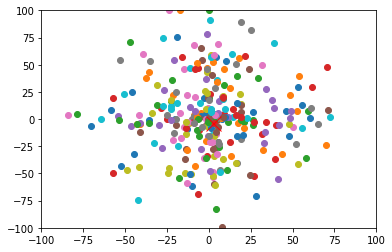

Melhor Ponto: 27079.114717299934

Iteração: 39


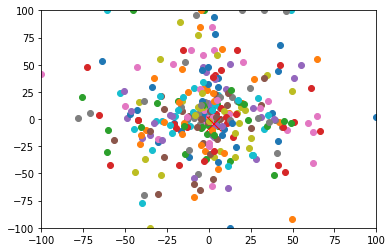

Melhor Ponto: 27079.114717299934

Iteração: 40


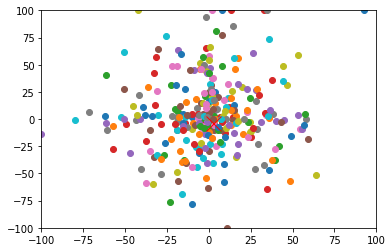

Melhor Ponto: 27079.114717299934

Iteração: 41


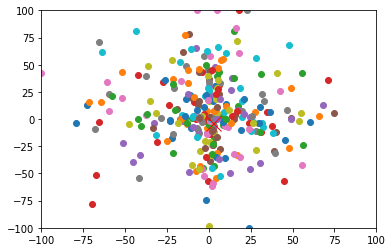

Melhor Ponto: 27079.114717299934

Iteração: 42


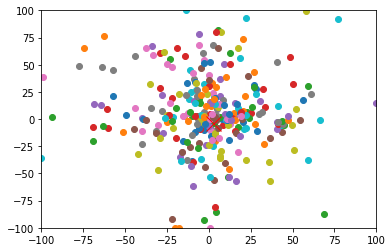

Melhor Ponto: 27079.114717299934

Iteração: 43


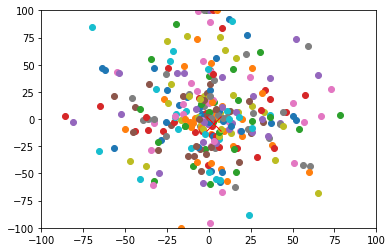

Melhor Ponto: 27079.114717299934

Iteração: 44


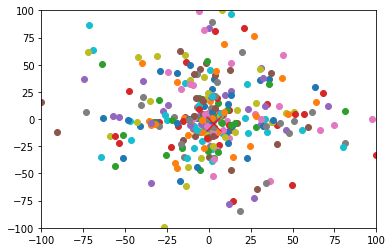

Melhor Ponto: 27079.114717299934

Iteração: 45


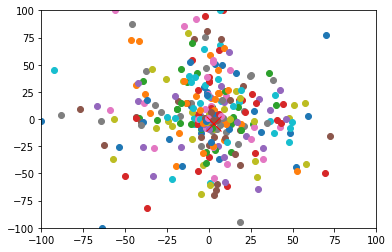

Melhor Ponto: 27079.114717299934

Iteração: 46


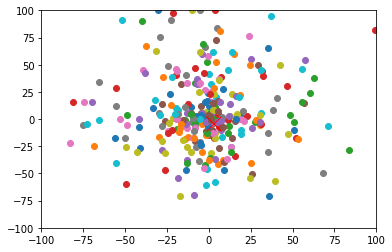

Melhor Ponto: 27079.114717299934

Iteração: 47


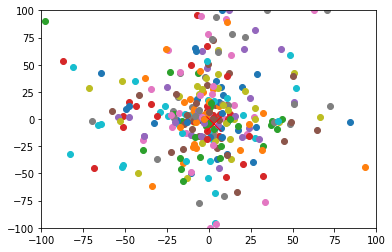

Melhor Ponto: 27079.114717299934

Iteração: 48


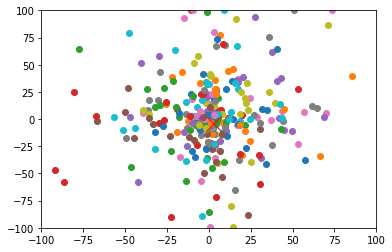

Melhor Ponto: 27079.114717299934

Iteração: 49


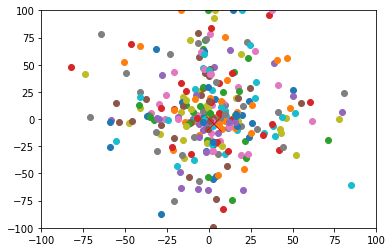

Melhor Ponto: 27079.114717299934

Iteração: 50


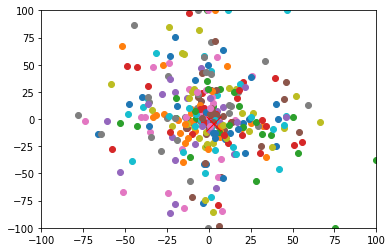

Melhor Ponto: 27079.114717299934

Iteração: 51


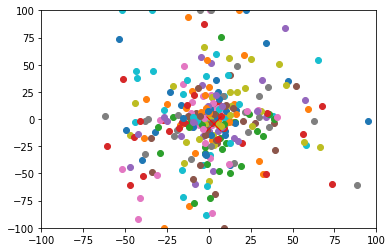

Melhor Ponto: 27079.114717299934

Iteração: 52


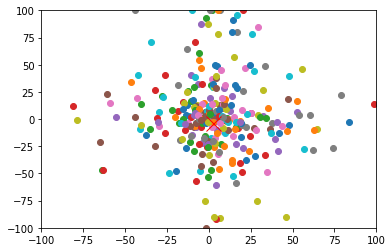

Melhor Ponto: 27079.114717299934

Iteração: 53


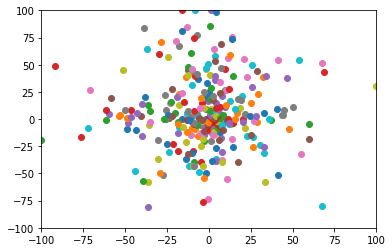

Melhor Ponto: 27079.114717299934

Iteração: 54


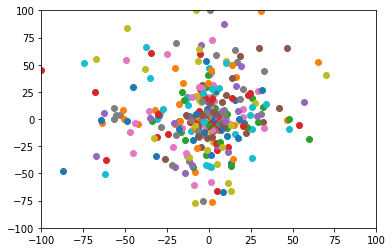

Melhor Ponto: 27079.114717299934

Iteração: 55


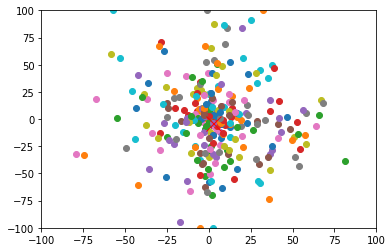

Melhor Ponto: 27079.114717299934

Iteração: 56


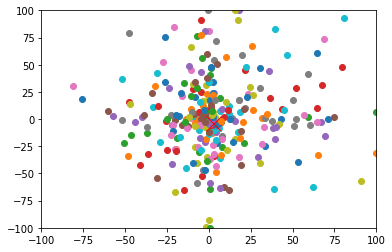

Melhor Ponto: 27079.114717299934

Iteração: 57


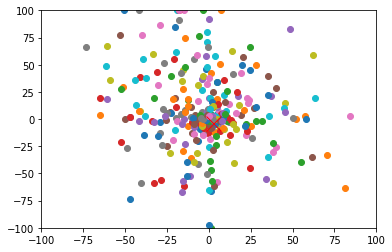

Melhor Ponto: 27079.114717299934

Iteração: 58


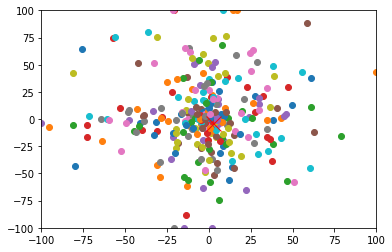

Melhor Ponto: 27079.114717299934

Iteração: 59


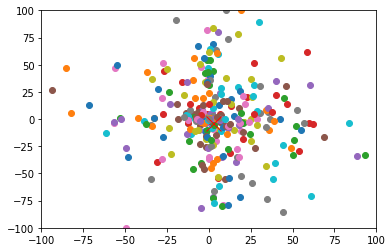

Melhor Ponto: 27079.114717299934

Iteração: 60


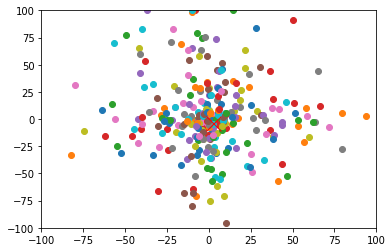

Melhor Ponto: 27079.114717299934

Iteração: 61


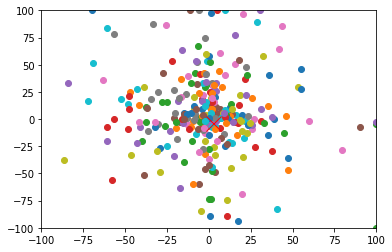

Melhor Ponto: 27079.114717299934

Iteração: 62


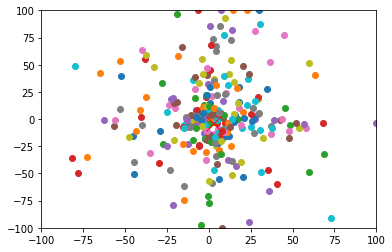

Melhor Ponto: 27079.114717299934

Iteração: 63


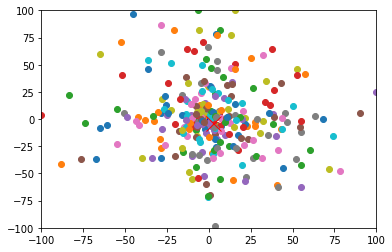

Melhor Ponto: 27079.114717299934

Iteração: 64


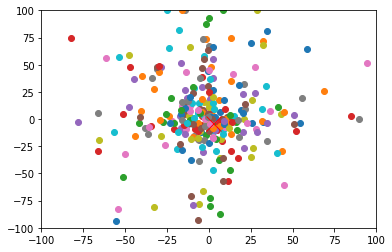

Melhor Ponto: 27079.114717299934

Iteração: 65


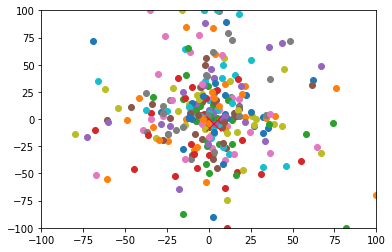

Melhor Ponto: 27079.114717299934

Iteração: 66


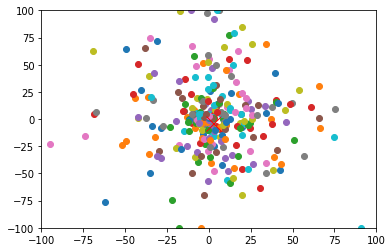

Melhor Ponto: 27079.114717299934

Iteração: 67


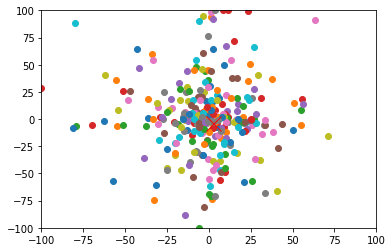

Melhor Ponto: 27079.114717299934

Iteração: 68


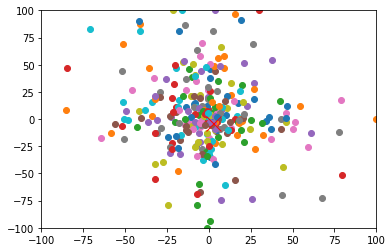

Melhor Ponto: 27079.114717299934

Iteração: 69


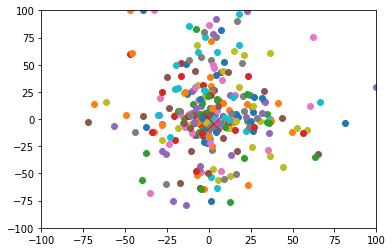

Melhor Ponto: 27079.114717299934

Iteração: 70


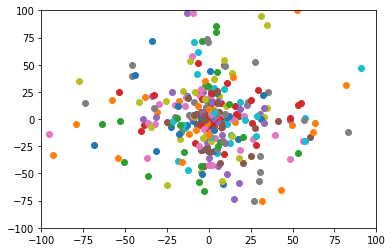

Melhor Ponto: 27079.114717299934

Iteração: 71


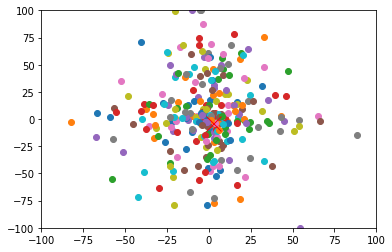

Melhor Ponto: 27079.114717299934

Iteração: 72


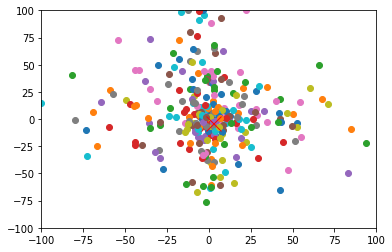

Melhor Ponto: 27079.114717299934

Iteração: 73


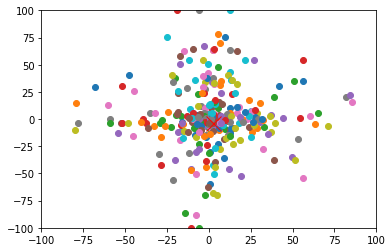

Melhor Ponto: 27079.114717299934

Iteração: 74


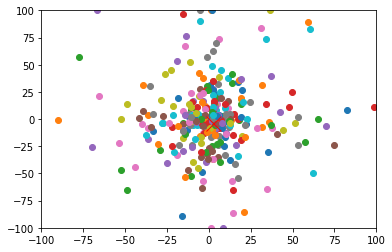

Melhor Ponto: 27079.114717299934

Iteração: 75


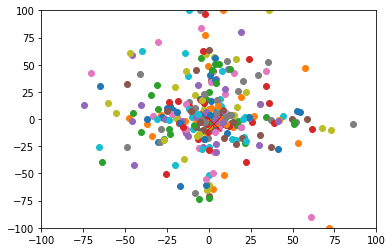

Melhor Ponto: 27079.114717299934

Iteração: 76


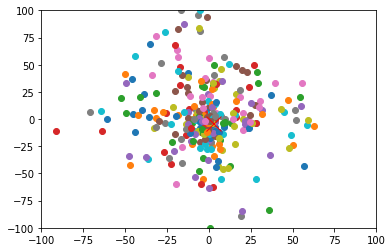

Melhor Ponto: 27079.114717299934

Iteração: 77


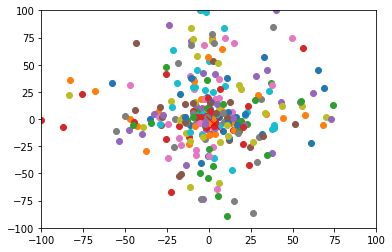

Melhor Ponto: 27079.114717299934

Iteração: 78


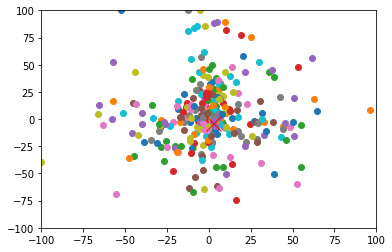

Melhor Ponto: 27079.114717299934

Iteração: 79


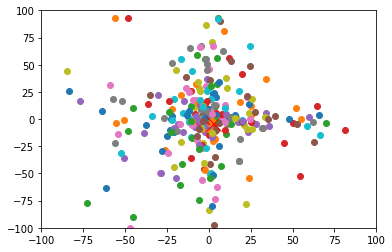

Melhor Ponto: 27079.114717299934

Iteração: 80


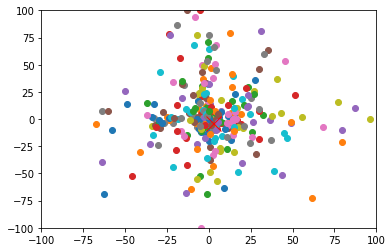

Melhor Ponto: 27079.114717299934

Iteração: 81


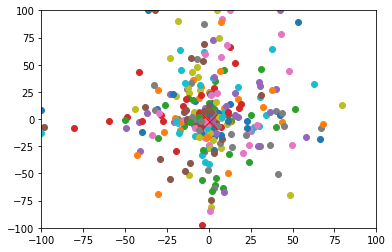

Melhor Ponto: 13435.540386976501

Iteração: 82


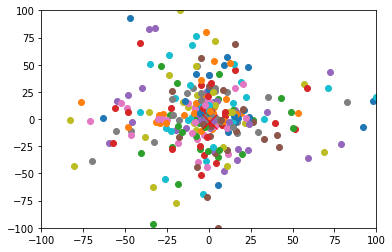

Melhor Ponto: 13435.540386976501

Iteração: 83


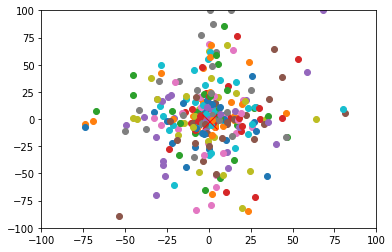

Melhor Ponto: 13435.540386976501

Iteração: 84


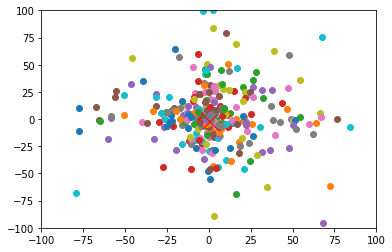

Melhor Ponto: 13435.540386976501

Iteração: 85


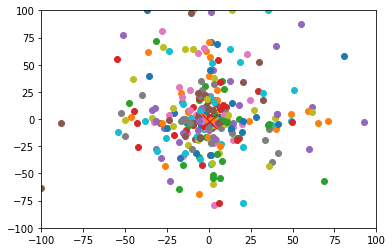

Melhor Ponto: 13435.540386976501

Iteração: 86


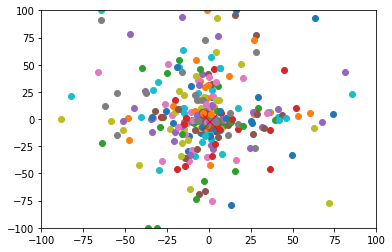

Melhor Ponto: 13435.540386976501

Iteração: 87


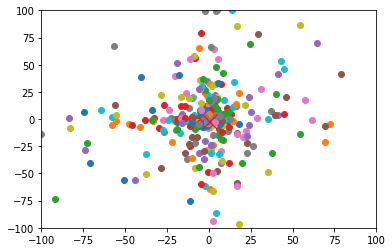

Melhor Ponto: 13435.540386976501

Iteração: 88


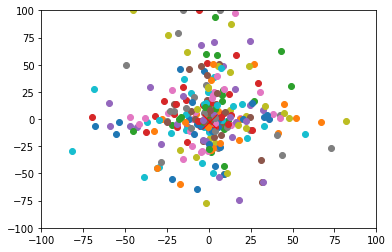

Melhor Ponto: 13435.540386976501

Iteração: 89


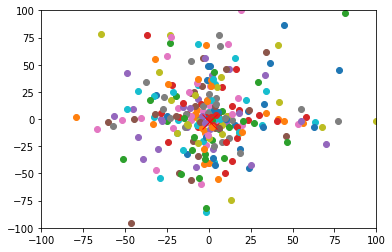

Melhor Ponto: 13435.540386976501

Iteração: 90


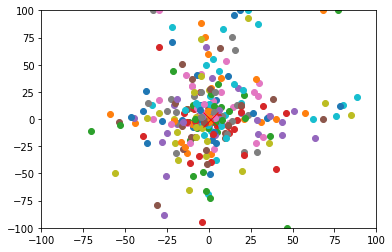

Melhor Ponto: 7632.655229731668

Iteração: 91


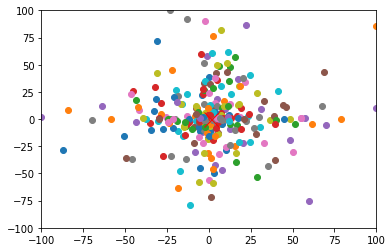

Melhor Ponto: 2144.554155256412

Iteração: 92


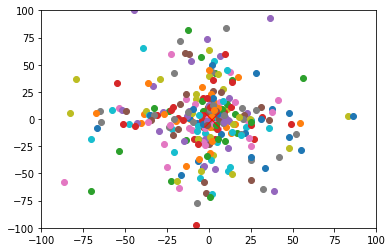

Melhor Ponto: 2144.554155256412

Iteração: 93


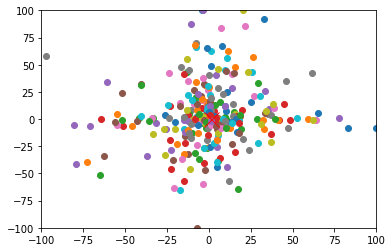

Melhor Ponto: 2144.554155256412

Iteração: 94


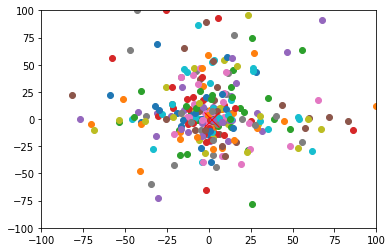

Melhor Ponto: 2144.554155256412

Iteração: 95


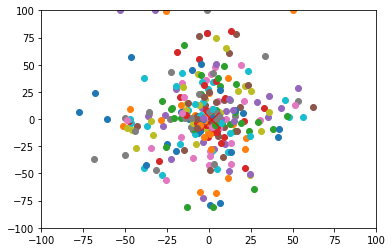

Melhor Ponto: 2144.554155256412

Iteração: 96


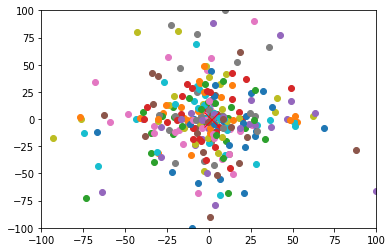

Melhor Ponto: 2144.554155256412

Iteração: 97


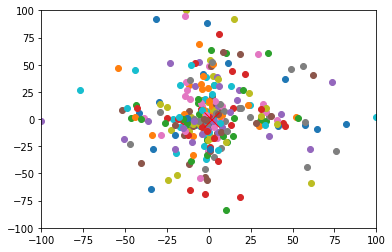

Melhor Ponto: 2144.554155256412

Iteração: 98


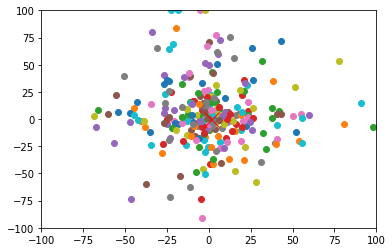

Melhor Ponto: 2144.554155256412

Iteração: 99


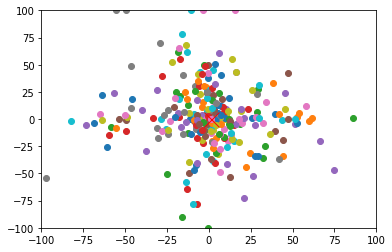

Melhor Ponto: 2144.554155256412

Iteração: 100


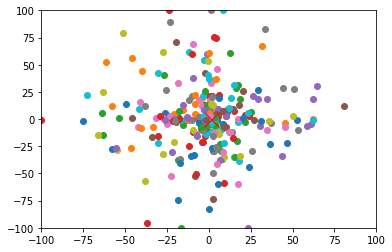

Melhor Ponto: 2144.554155256412

Iteração: 101


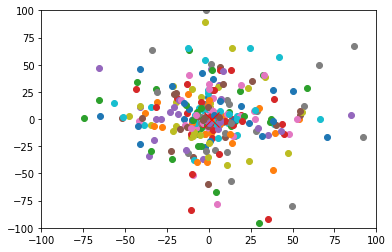

Melhor Ponto: 2144.554155256412

Iteração: 102


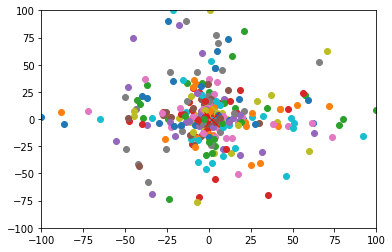

Melhor Ponto: 2144.554155256412

Iteração: 103


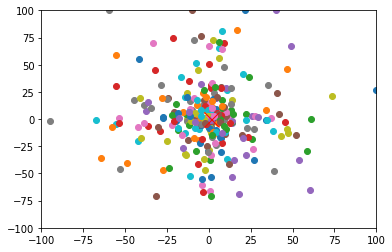

Melhor Ponto: 2144.554155256412

Iteração: 104


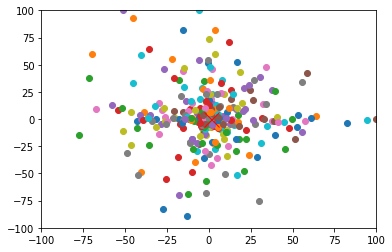

Melhor Ponto: 2144.554155256412

Iteração: 105


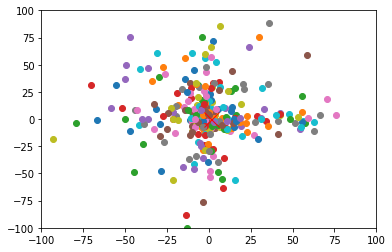

Melhor Ponto: 2144.554155256412

Iteração: 106


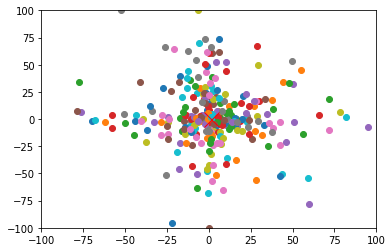

Melhor Ponto: 2144.554155256412

Iteração: 107


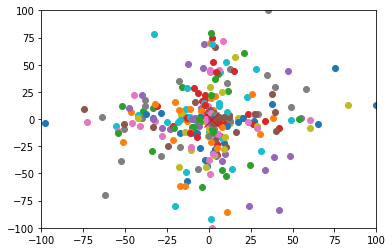

Melhor Ponto: 2144.554155256412

Iteração: 108


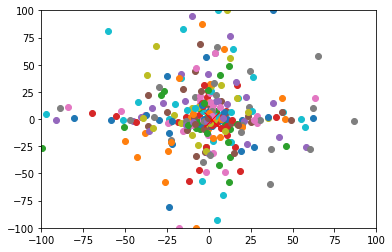

Melhor Ponto: 2144.554155256412

Iteração: 109


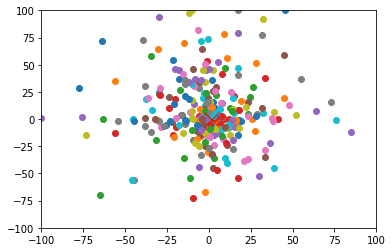

Melhor Ponto: 2144.554155256412

Iteração: 110


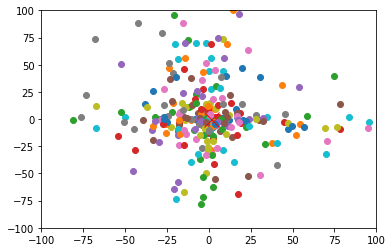

Melhor Ponto: 2144.554155256412

Iteração: 111


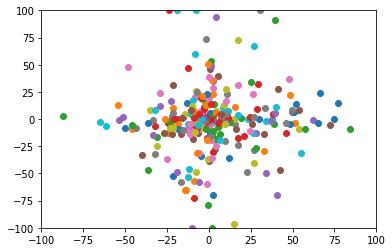

Melhor Ponto: 2144.554155256412

Iteração: 112


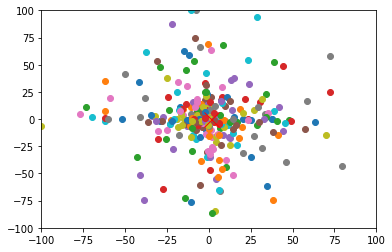

Melhor Ponto: 2144.554155256412

Iteração: 113


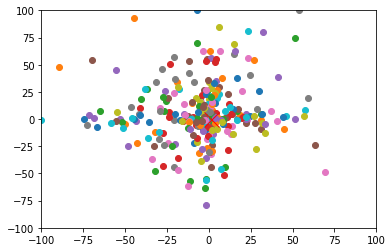

Melhor Ponto: 2144.554155256412

Iteração: 114


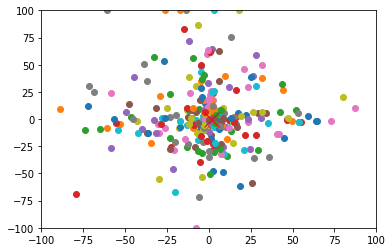

Melhor Ponto: 2144.554155256412

Iteração: 115


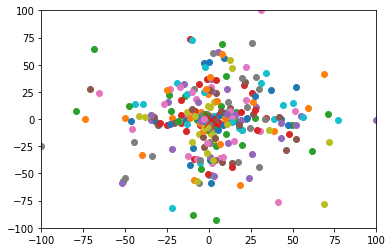

Melhor Ponto: 2144.554155256412

Iteração: 116


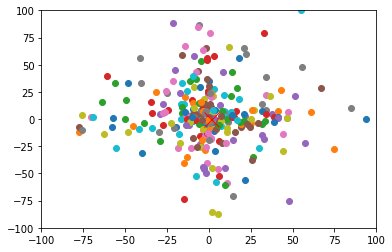

Melhor Ponto: 2144.554155256412

Iteração: 117


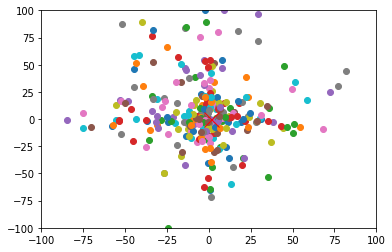

Melhor Ponto: 2144.554155256412

Iteração: 118


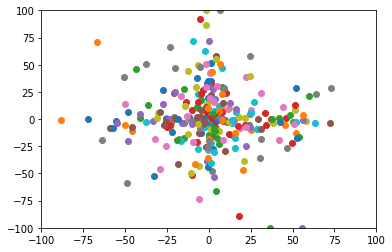

Melhor Ponto: 2144.554155256412

Iteração: 119


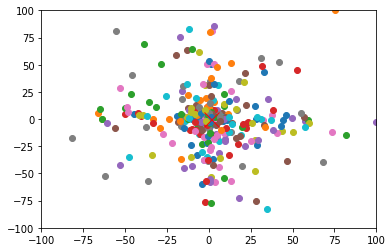

Melhor Ponto: 2144.554155256412

Iteração: 120


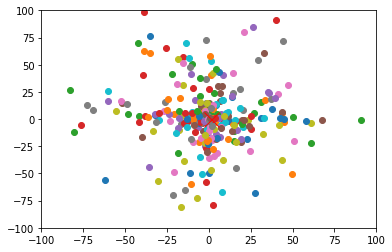

Melhor Ponto: 2144.554155256412

Iteração: 121


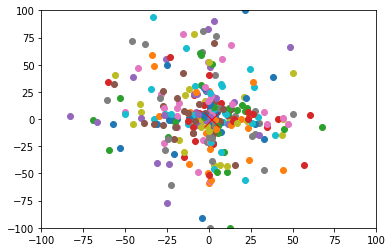

Melhor Ponto: 2144.554155256412

Iteração: 122


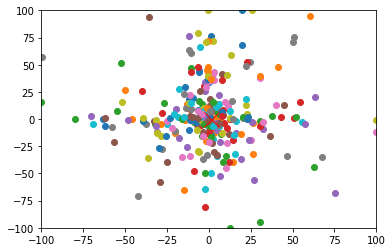

Melhor Ponto: 2144.554155256412

Iteração: 123


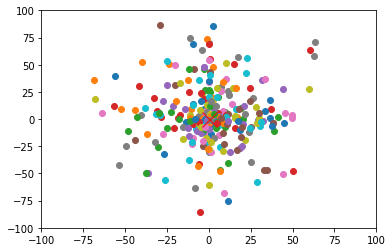

Melhor Ponto: 1149.0727588980012

Iteração: 124


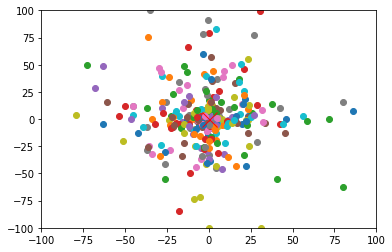

Melhor Ponto: 1149.0727588980012

Iteração: 125


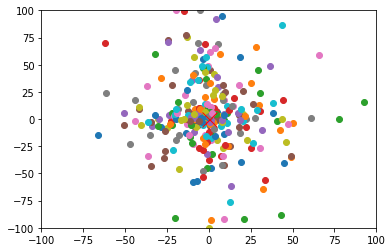

Melhor Ponto: 1149.0727588980012

Iteração: 126


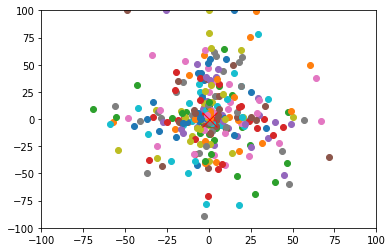

Melhor Ponto: 1149.0727588980012

Iteração: 127


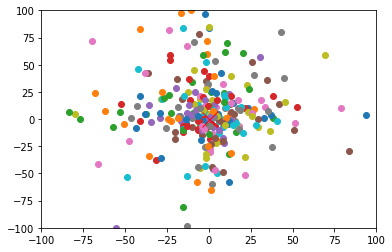

Melhor Ponto: 1149.0727588980012

Iteração: 128


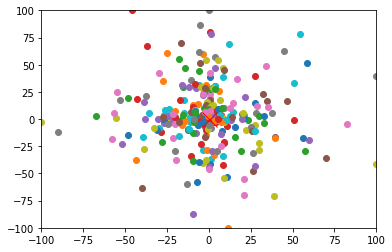

Melhor Ponto: 1149.0727588980012

Iteração: 129


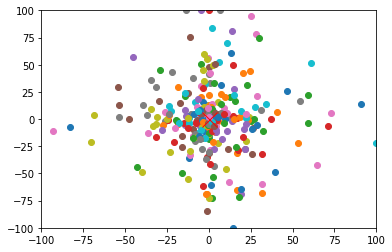

Melhor Ponto: 1149.0727588980012

Iteração: 130


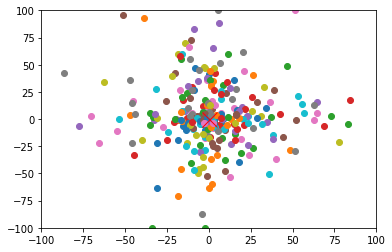

Melhor Ponto: 1149.0727588980012

Iteração: 131


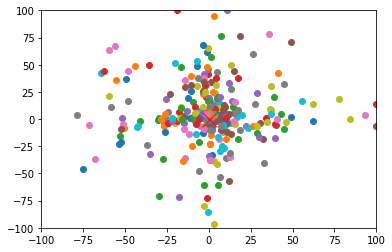

Melhor Ponto: 1149.0727588980012

Iteração: 132


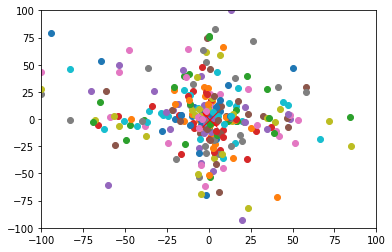

Melhor Ponto: 1149.0727588980012

Iteração: 133


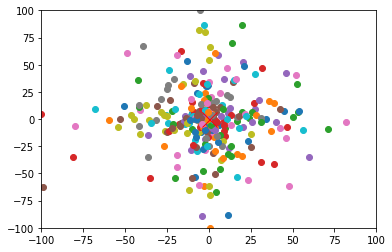

Melhor Ponto: 1149.0727588980012

Iteração: 134


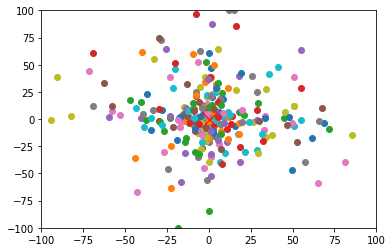

Melhor Ponto: 1149.0727588980012

Iteração: 135


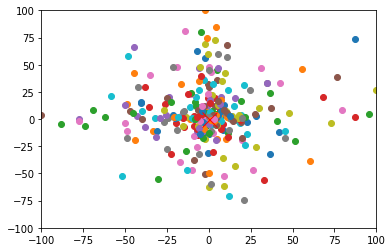

Melhor Ponto: 1149.0727588980012

Iteração: 136


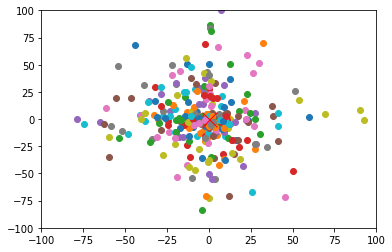

Melhor Ponto: 1149.0727588980012

Iteração: 137


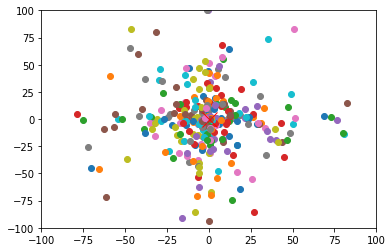

Melhor Ponto: 1149.0727588980012

Iteração: 138


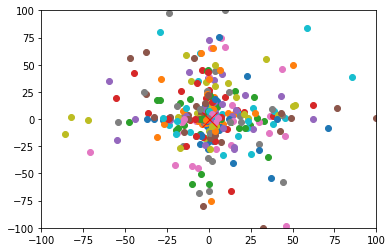

Melhor Ponto: 1149.0727588980012

Iteração: 139


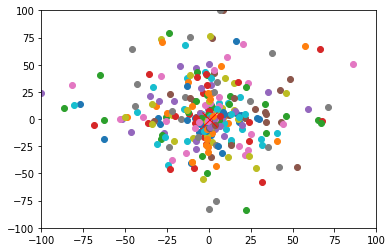

Melhor Ponto: 1149.0727588980012

Iteração: 140


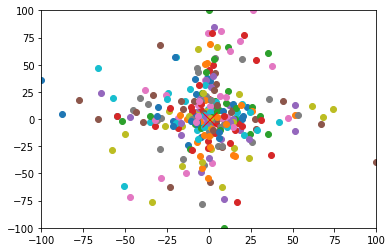

Melhor Ponto: 1149.0727588980012

Iteração: 141


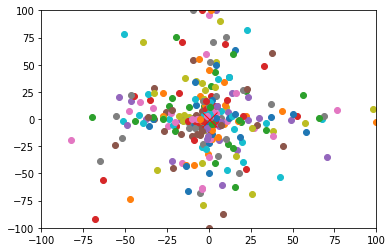

Melhor Ponto: 1149.0727588980012

Iteração: 142


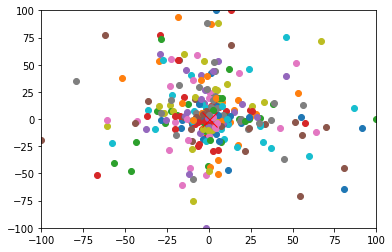

Melhor Ponto: 1149.0727588980012

Iteração: 143


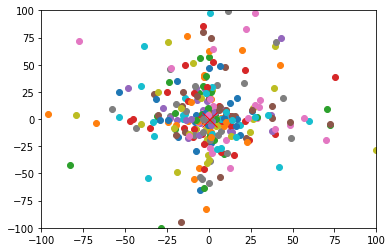

Melhor Ponto: 1149.0727588980012

Iteração: 144


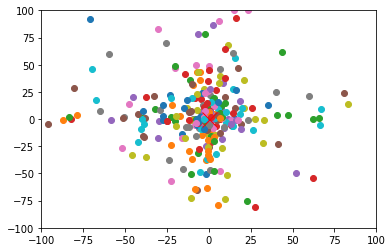

Melhor Ponto: 1149.0727588980012

Iteração: 145


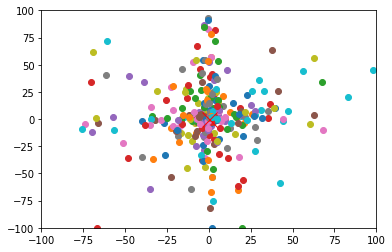

Melhor Ponto: 1149.0727588980012

Iteração: 146


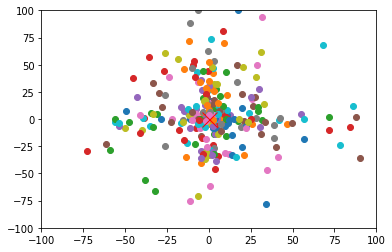

Melhor Ponto: 1149.0727588980012

Iteração: 147


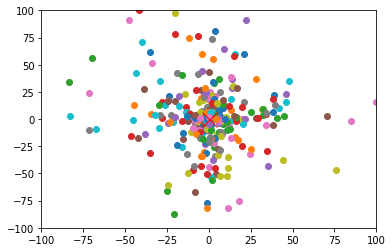

Melhor Ponto: 1149.0727588980012

Iteração: 148


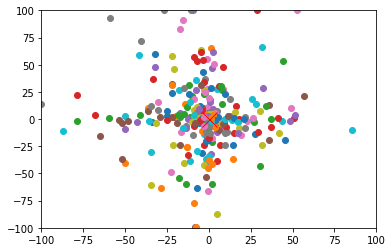

Melhor Ponto: 1149.0727588980012

Iteração: 149


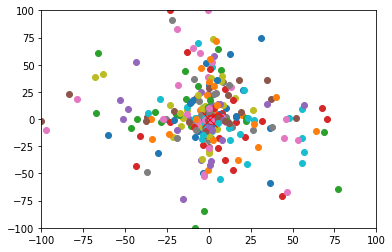

Melhor Ponto: 1149.0727588980012

Iteração: 150


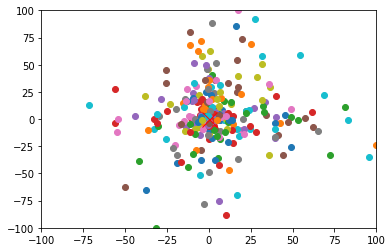

Melhor Ponto: 1149.0727588980012

Iteração: 151


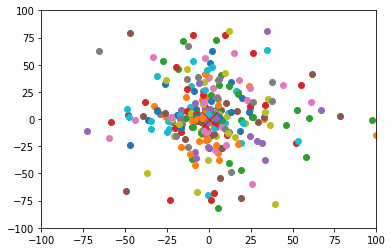

Melhor Ponto: 1149.0727588980012

Iteração: 152


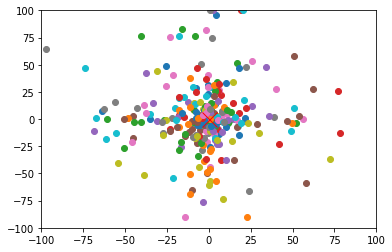

Melhor Ponto: 1149.0727588980012

Iteração: 153


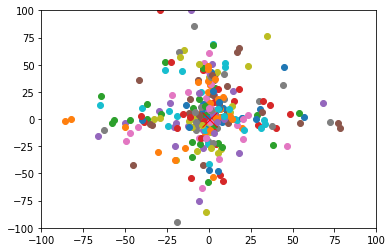

Melhor Ponto: 1149.0727588980012

Iteração: 154


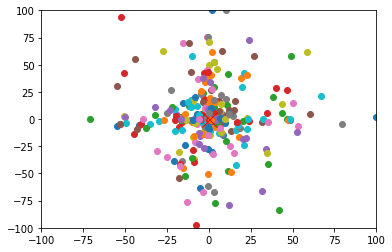

Melhor Ponto: 1149.0727588980012

Iteração: 155


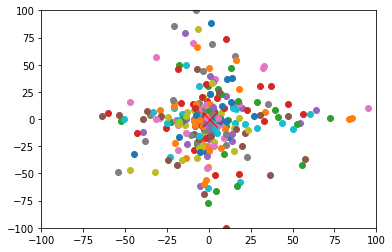

Melhor Ponto: 1149.0727588980012

Iteração: 156


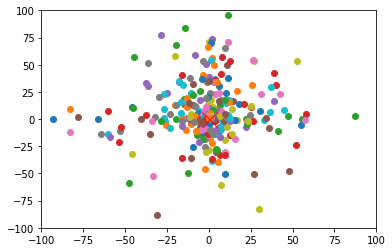

Melhor Ponto: 1149.0727588980012

Iteração: 157


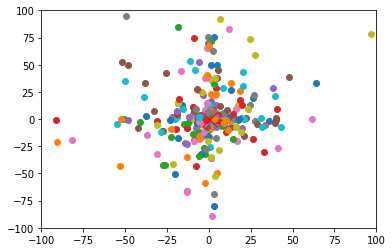

Melhor Ponto: 1149.0727588980012

Iteração: 158


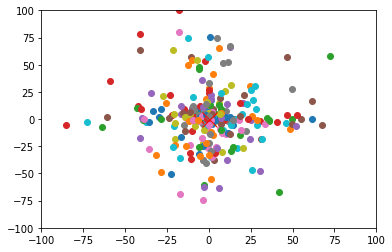

Melhor Ponto: 1149.0727588980012

Iteração: 159


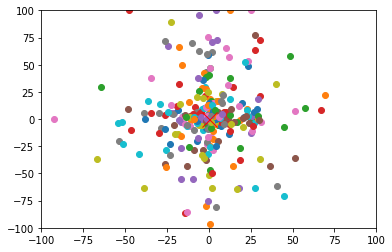

Melhor Ponto: 1149.0727588980012

Iteração: 160


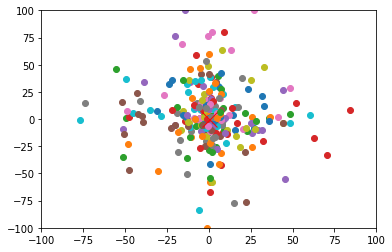

Melhor Ponto: 1149.0727588980012

Iteração: 161


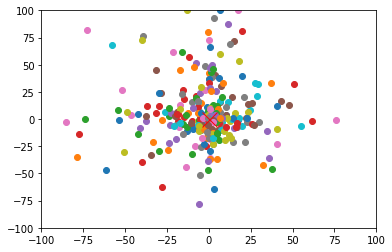

Melhor Ponto: 1149.0727588980012

Iteração: 162


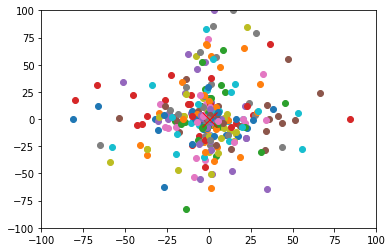

Melhor Ponto: 1149.0727588980012

Iteração: 163


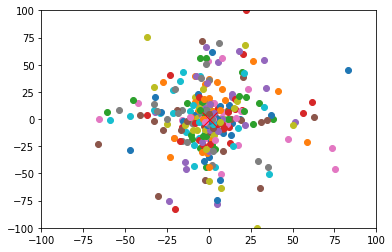

Melhor Ponto: 1149.0727588980012

Iteração: 164


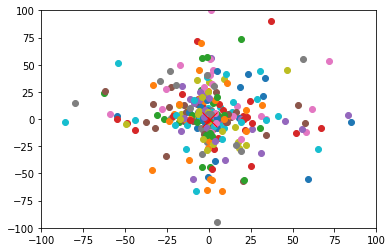

Melhor Ponto: 1149.0727588980012

Iteração: 165


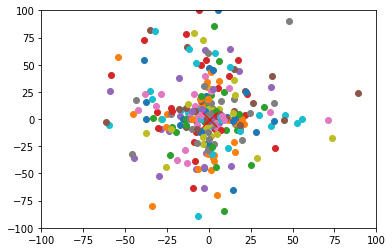

Melhor Ponto: 1149.0727588980012

Iteração: 166


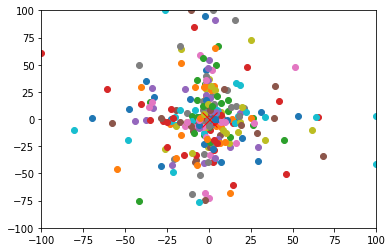

Melhor Ponto: 1149.0727588980012

Iteração: 167


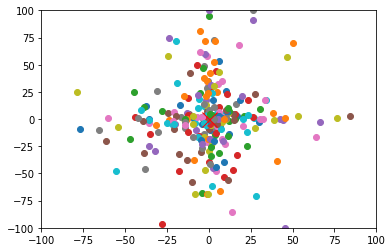

Melhor Ponto: 1149.0727588980012

Iteração: 168


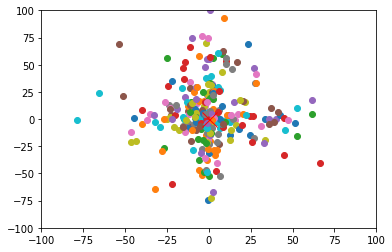

Melhor Ponto: 1149.0727588980012

Iteração: 169


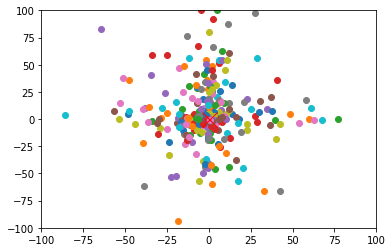

Melhor Ponto: 1149.0727588980012

Iteração: 170


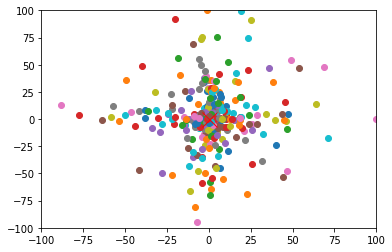

Melhor Ponto: 1149.0727588980012

Iteração: 171


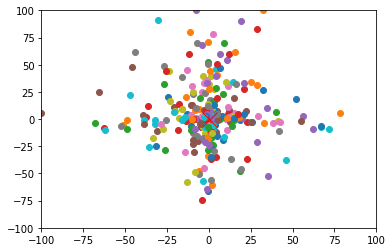

Melhor Ponto: 1149.0727588980012

Iteração: 172


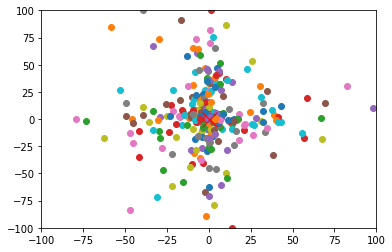

Melhor Ponto: 1149.0727588980012

Iteração: 173


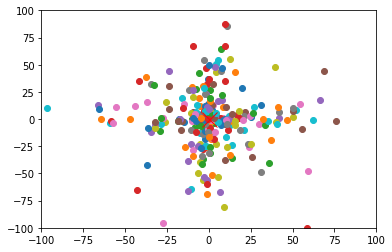

Melhor Ponto: 1149.0727588980012

Iteração: 174


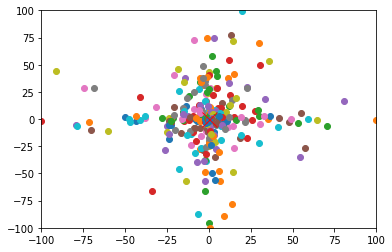

Melhor Ponto: 1149.0727588980012

Iteração: 175


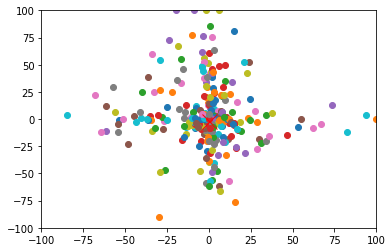

Melhor Ponto: 799.4180908292699

Iteração: 176


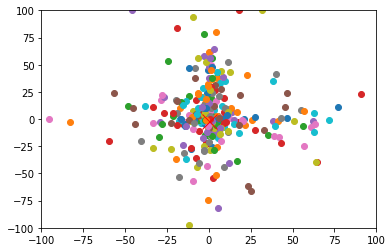

Melhor Ponto: 799.4180908292699

Iteração: 177


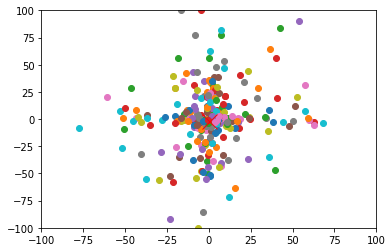

Melhor Ponto: 799.4180908292699

Iteração: 178


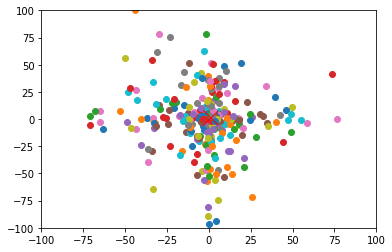

Melhor Ponto: 562.870694787237

Iteração: 179


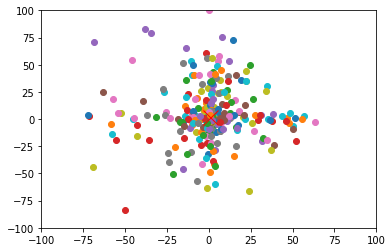

Melhor Ponto: 562.870694787237

Iteração: 180


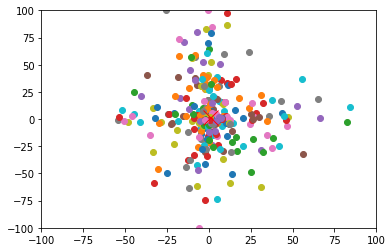

Melhor Ponto: 562.870694787237

Iteração: 181


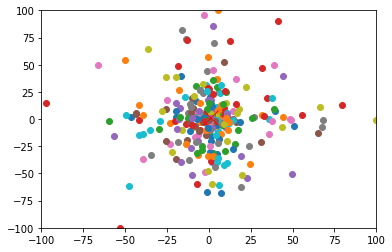

Melhor Ponto: 562.870694787237

Iteração: 182


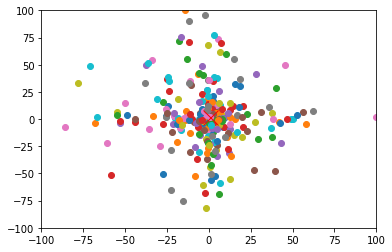

Melhor Ponto: 562.870694787237

Iteração: 183


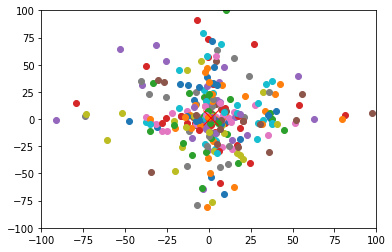

Melhor Ponto: 562.870694787237

Iteração: 184


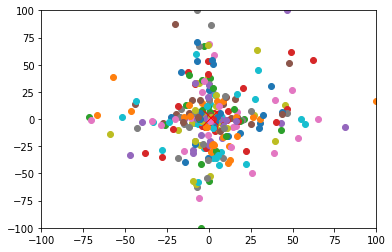

Melhor Ponto: 562.870694787237

Iteração: 185


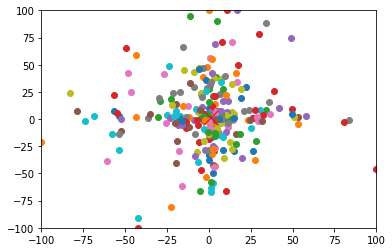

Melhor Ponto: 562.870694787237

Iteração: 186


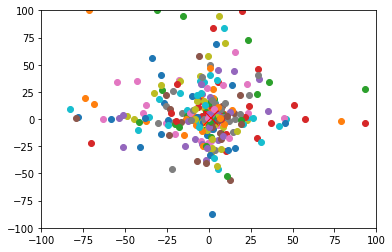

Melhor Ponto: 562.870694787237

Iteração: 187


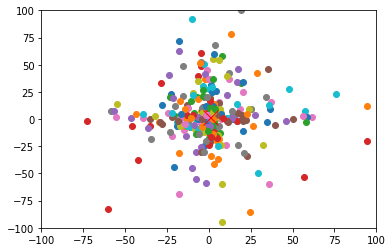

Melhor Ponto: 562.870694787237

Iteração: 188


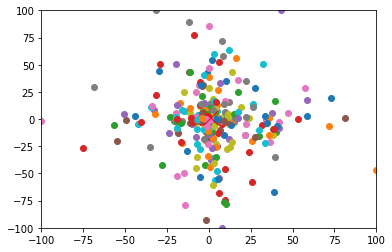

Melhor Ponto: 562.870694787237

Iteração: 189


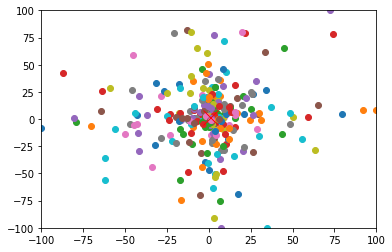

Melhor Ponto: 562.870694787237

Iteração: 190


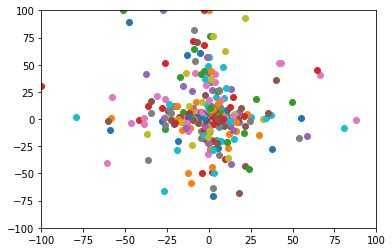

Melhor Ponto: 562.870694787237

Iteração: 191


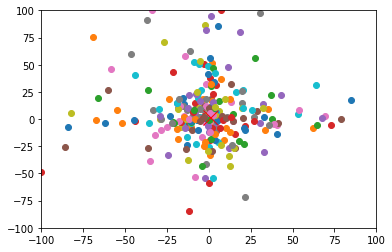

Melhor Ponto: 562.870694787237

Iteração: 192


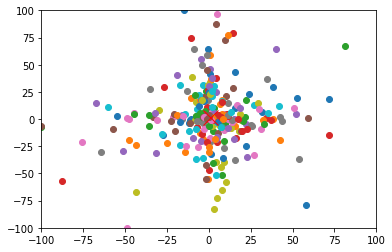

Melhor Ponto: 562.870694787237

Iteração: 193


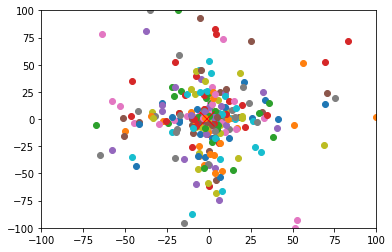

Melhor Ponto: 464.24731864067667

Iteração: 194


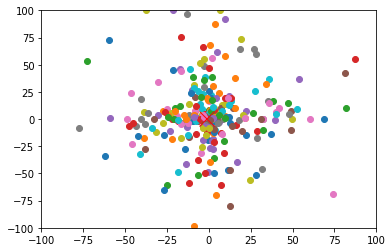

Melhor Ponto: 464.24731864067667

Iteração: 195


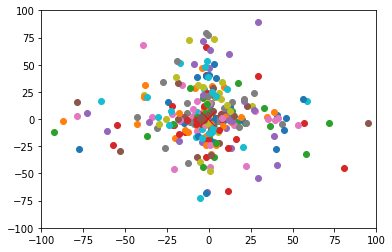

Melhor Ponto: 347.20028228598545

Iteração: 196


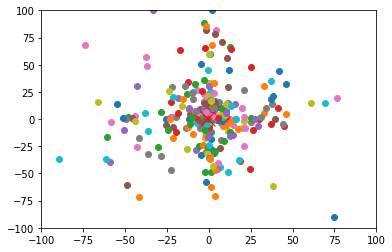

Melhor Ponto: 347.20028228598545

Iteração: 197


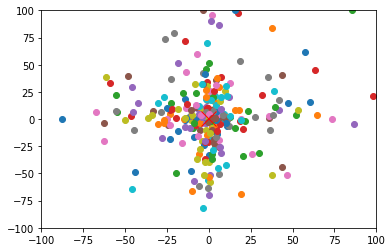

Melhor Ponto: 177.17575030578513

Iteração: 198


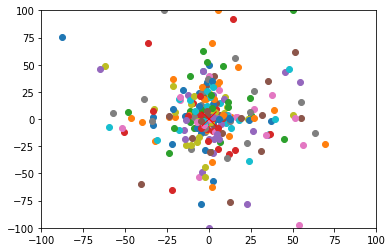

Melhor Ponto: 177.17575030578513

Iteração: 199


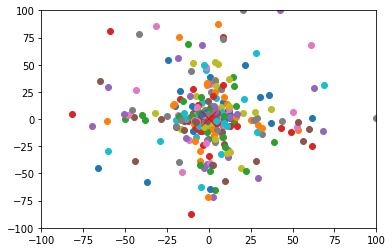

Melhor Ponto: 177.17575030578513

Iteração: 200


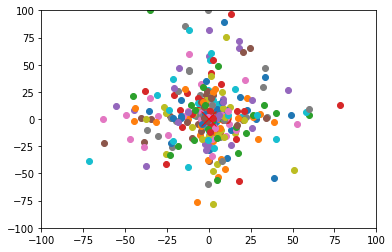

Melhor Ponto: 177.17575030578513



In [ ]:
#otimizador PSO
fitness_gbest = float('inf')
lista_posicao_gbest = []
lista_melhores_valores = []
for i in range(ITERACOES):
  print("Iteração: {:.0f}".format(i+1))
  for j in range(POPULACAO):
    calculo_fitness(PARTICULAS[j])
    if  PARTICULAS[j].fitness < fitness_gbest:
     fitness_gbest = PARTICULAS[j].fitness
     lista_posicao_gbest = list (PARTICULAS[j].lista_posicao)
  for j in range(POPULACAO):
    atualizacao_velocidade_global(PARTICULAS[j],lista_posicao_gbest)
    atualiza_posicao(PARTICULAS[j],LIMITES)
  lista_melhores_valores.append(fitness_gbest)
  #plota os eixos
  plt.axis([E1, E2, E1, E2])
  #ponto ideal
  plt.plot(0,0, marker='*', markersize=10, color='b')
  #exibe o enxame
  for i in range(POPULACAO):
    p = PARTICULAS[i]
    #variáveis das DIMENSÕES do problema
    d1,d2,d3,d4,d5,d6 = zip(p.lista_posicao)
    plt.plot(d1,d2,d3,d4,d5,d6, marker='o')
  #ponto gbest
  plt.plot(lista_posicao_gbest[0],lista_posicao_gbest[1], marker='x', markersize=15, color='r')
  plt.show()
  print('Melhor Ponto:',fitness_gbest)
  print("")

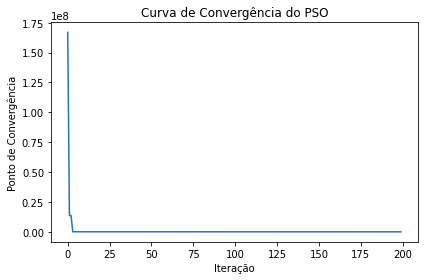

In [ ]:
#resultado
plt.plot(lista_melhores_valores)
plt.title("Curva de Convergência do PSO")
plt.xlabel("Iteração")
plt.ylabel("Ponto de Convergência")
plt.tight_layout()